## Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import random
import os
import numpy as np

from matplotlib import pyplot as plt

import shap

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import f1_score

In [ ]:
class CFG:
    SEED = 42

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG.SEED) # Seed 고정

## Data Load

In [ ]:
X_train = pd.read_csv('/content/drive/MyDrive/유전체공모전/data/X_train_fine.csv')
X_test = pd.read_csv('/content/drive/MyDrive/유전체공모전/data/X_test_fine.csv')
y_train = pd.read_csv('/content/drive/MyDrive/유전체공모전/data/y_train_fine.csv')
submit = pd.read_csv('/content/drive/MyDrive/유전체공모전/data/sample_submission.csv')
y_train = y_train['class']

In [ ]:
X_sex = pd.concat([X_train,X_test.loc[[103]]]).reset_index(drop=True)

In [ ]:
X_sex_list = X_sex.transpose().corr().sort_values(by=342, ascending=False).iloc[:300,-1:].index.to_list()
X_sex_list.remove(342)

In [ ]:
X_train_01 = X_train.loc[X_sex_list,:]
y_train_01 = pd.DataFrame(y_train).loc[X_sex_list,:]['class']

In [ ]:
def evaluate_macroF1_lgb(truth, predictions):  
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True) 

Learning rate set to 0.074402
0:	learn: 0.9689848	total: 80.2ms	remaining: 1m 20s
1:	learn: 0.9523672	total: 101ms	remaining: 50.6s
2:	learn: 0.9552988	total: 122ms	remaining: 40.7s
3:	learn: 0.9649096	total: 146ms	remaining: 36.4s
4:	learn: 0.9678356	total: 163ms	remaining: 32.4s
5:	learn: 0.9619876	total: 178ms	remaining: 29.5s
6:	learn: 0.9590643	total: 206ms	remaining: 29.3s
7:	learn: 0.9561395	total: 226ms	remaining: 28.1s
8:	learn: 0.9619876	total: 258ms	remaining: 28.4s
9:	learn: 0.9649096	total: 294ms	remaining: 29.1s
10:	learn: 0.9590612	total: 312ms	remaining: 28.1s
11:	learn: 0.9678307	total: 339ms	remaining: 27.9s
12:	learn: 0.9707580	total: 355ms	remaining: 26.9s
13:	learn: 0.9707580	total: 381ms	remaining: 26.8s
14:	learn: 0.9736837	total: 416ms	remaining: 27.3s
15:	learn: 0.9766082	total: 452ms	remaining: 27.8s
16:	learn: 0.9766082	total: 472ms	remaining: 27.3s
17:	learn: 0.9766082	total: 503ms	remaining: 27.4s
18:	learn: 0.9766082	total: 517ms	remaining: 26.7s
19:	learn

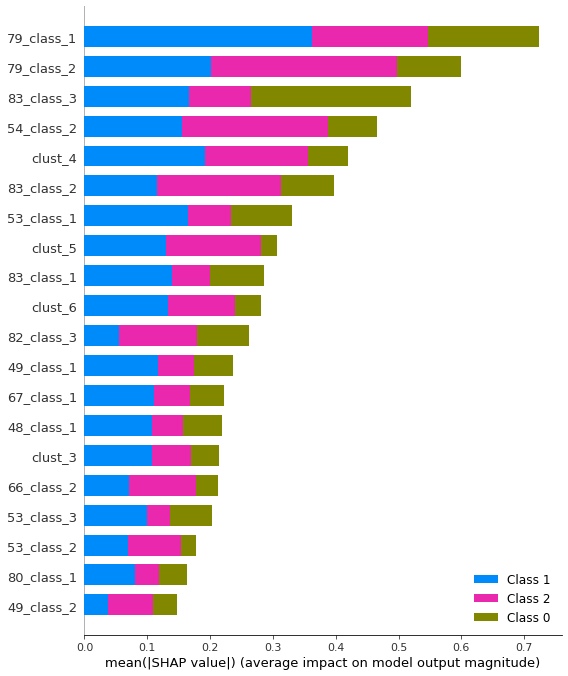

,column_name,shap_importance
79,79_class_1,0.361691
156,79_class_2,0.200824
240,clust_4,0.191706
237,83_class_3,0.166315
61,53_class_1,0.165279
...,...,...
142,63_class_2,0.0
45,37_class_1,0.0
47,39_class_1,0.0
48,40_class_1,0.0


In [ ]:
import shap

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
model = CatBoostClassifier(random_state=42,eval_metric="TotalF1:average=Macro").fit(X_train_01, y_train_01)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

shap_sum = np.abs(shap_values).mean(axis=1)[1,:]
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [ ]:
features_selected = importance_df.query('shap_importance < 0.000001').column_name.tolist()
X_train = X_train[features_selected]
X_test = X_test[features_selected]
X_train.shape, X_test.shape

((342, 42), (175, 42))

### Model_Baseline

In [ ]:
def evaluate_macroF1_lgb(truth, predictions):  
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True) 

In [ ]:
model = CatBoostClassifier(random_state=42,eval_metric="TotalF1:average=Macro")

In [ ]:
model.fit(X_train, y_train)

Learning rate set to 0.074913
0:	learn: 0.8310575	total: 2.25ms	remaining: 2.25s
1:	learn: 0.8222856	total: 4.83ms	remaining: 2.41s
2:	learn: 0.8385142	total: 6.36ms	remaining: 2.11s
3:	learn: 0.8375279	total: 8.43ms	remaining: 2.1s
4:	learn: 0.8561023	total: 10.5ms	remaining: 2.1s
5:	learn: 0.8622525	total: 12.7ms	remaining: 2.1s
6:	learn: 0.8648314	total: 14.7ms	remaining: 2.08s
7:	learn: 0.8795958	total: 16.7ms	remaining: 2.07s
8:	learn: 0.8823074	total: 18.8ms	remaining: 2.08s
9:	learn: 0.8824621	total: 21.3ms	remaining: 2.1s
10:	learn: 0.8851675	total: 23.3ms	remaining: 2.1s
11:	learn: 0.8823074	total: 25.5ms	remaining: 2.1s
12:	learn: 0.8973270	total: 27.7ms	remaining: 2.1s
13:	learn: 0.9031941	total: 29.7ms	remaining: 2.09s
14:	learn: 0.9031941	total: 31.7ms	remaining: 2.08s
15:	learn: 0.9122199	total: 33.8ms	remaining: 2.08s
16:	learn: 0.9121116	total: 36ms	remaining: 2.08s
17:	learn: 0.9092153	total: 38ms	remaining: 2.08s
18:	learn: 0.9091452	total: 40ms	remaining: 2.07s
19:	l

In [ ]:
submit['class'] = model.predict(X_test)

In [ ]:
submit.loc[[103]]

,id,class
103,TEST_103,C


In [ ]:
Best_sub = pd.read_csv('/content/drive/MyDrive/유전체공모전/submissions/baseline12.csv')

## Emsemble

In [ ]:
# Last_submmit.to_csv('/content/drive/MyDrive/유전체공모전/submissions/Fine_01.csv', index=False)